<a href="https://colab.research.google.com/github/Akshat13shah/data_augmentation_and_modeltraining/blob/main/Model_Training_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS203 Lab Assignment 5

### Team Number: 18
* Name: Paras Prashant Shirvale
* Roll No: 23110232
---
* Name: Akshat Shah
* Roll No: 23110293
---

### Task 2: Model Training
*Note: Initial weights of the model should be the same when training with both datasets.*

1. Choose (microsoft/resnet-50)model from the hugging face and initialize its new weights.
2. Train model(created in the above point) on a downloaded dataset, without augmentation.
3. Train model(created in the first point) on a downloaded dataset with augmentation.
4. Get the precision, recall, F1 score, and accuracy of both the models on the test set.


In [29]:
# %pip install transformers
# %pip install seaborn
from transformers import AutoImageProcessor, ResNetConfig, ResNetForImageClassification
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import torch
import os
import random
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn
from PIL import Image


In [30]:
# Dataset paths
path = "/teamspace/studios/this_studio/data_augmentation_and_modeltraining/test"

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ResNet normalization
])

In [31]:
# Load dataset
dataset = datasets.ImageFolder(root=path, transform=transform)
n = len(dataset)
cats = dataset.imgs[:70]
dogs = dataset.imgs[70:]

train = cats[:56] + dogs[:56]
test = cats[56:] + dogs[56:]

print(len(train),len(test))

random.shuffle(train)

112 28


In [32]:
class CustomDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path, label = self.img_list[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# Assuming 'train' and 'test' lists are already created and shuffled
train_dataset = CustomDataset(train, transform=transform)
test_dataset = CustomDataset(test, transform=transform)

# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example of using the DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])


torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([16, 3, 224, 224]) torch.Size([16])


In [33]:
classes = dataset.classes

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
# Load the model configuration and set it up with random weights initialization
config = ResNetConfig.from_pretrained("microsoft/resnet-50")
config.num_labels = len(classes)

# Initialize the model with the custom configuration (without pretrained weights)
model = ResNetForImageClassification(config)

# Initialize weights randomly using a custom function if needed
def init_weights(module):
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_normal_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

model.apply(init_weights)


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [36]:
model.config

ResNetConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_bottleneck": false,
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "layer_type": "bottleneck",
  "model_type": "resnet",
  "num_channels": 3,
  "out_features": [
    "stage4"
  ],
  "out_indices": [
    4
  ],
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.48.3"
}

In [37]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [38]:
def accuracy(test_loader, model, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")

# Function to train the model
def train_model(train_loader, model, device, num_epochs=5):
    model.to(device)  # Move the model to the device (GPU or CPU)
    model.train()  # Set the model to training mode

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Use Adam optimizer
    criterion = torch.nn.CrossEntropyLoss()  # Use CrossEntropy loss for classification

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Move both inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            model.train()
            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs).logits  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation

            optimizer.step()  # Update model parameters

            running_loss += loss.item()  # Track the loss

        # Print the loss for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
        accuracy(test_loader, model, device)

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(test_loader, model, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    
    # Initialize metric containers
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all true labels and predicted labels for metric calculations
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Print the results
    print(f"Test Accuracy: {accuracy:.2f}")
    print(f"Test Precision: {precision:.2f}")
    print(f"Test Recall: {recall:.2f}")
    print(f"Test F1 Score: {f1:.2f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



In [40]:
# Step 8: Train the model
train_model(train_loader, model, device, num_epochs=25)

Epoch 1/25, Loss: 0.8221558034420013
Test Accuracy: 50.0%
Epoch 2/25, Loss: 0.7647288888692856
Test Accuracy: 50.0%
Epoch 3/25, Loss: 0.7334993183612823
Test Accuracy: 50.0%
Epoch 4/25, Loss: 0.5504532977938652
Test Accuracy: 50.0%
Epoch 5/25, Loss: 0.4792247861623764
Test Accuracy: 50.0%
Epoch 6/25, Loss: 0.5106937140226364
Test Accuracy: 50.0%
Epoch 7/25, Loss: 0.4556847810745239
Test Accuracy: 50.0%
Epoch 8/25, Loss: 0.3894340991973877
Test Accuracy: 50.0%
Epoch 9/25, Loss: 0.2870013415813446
Test Accuracy: 50.0%
Epoch 10/25, Loss: 0.27221181988716125
Test Accuracy: 50.0%
Epoch 11/25, Loss: 0.25890907645225525
Test Accuracy: 46.42857142857143%
Epoch 12/25, Loss: 0.3013465143740177
Test Accuracy: 42.857142857142854%
Epoch 13/25, Loss: 0.27810925245285034
Test Accuracy: 46.42857142857143%
Epoch 14/25, Loss: 0.24598414823412895
Test Accuracy: 53.57142857142857%
Epoch 15/25, Loss: 0.12730303220450878
Test Accuracy: 46.42857142857143%
Epoch 16/25, Loss: 0.2502104602754116
Test Accuracy: 

Test Accuracy: 0.57
Test Precision: 0.61
Test Recall: 0.57
Test F1 Score: 0.53


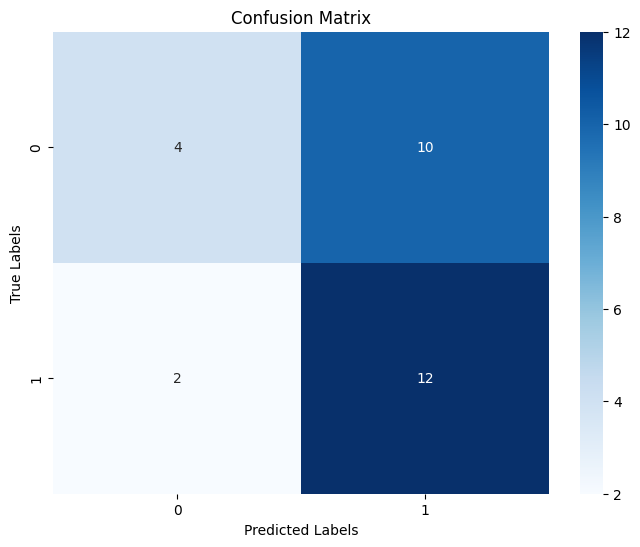

In [41]:
evaluate_model(test_loader, model, device)

Test Accuracy: 0.83
Test Precision: 0.86
Test Recall: 0.83
Test F1 Score: 0.83


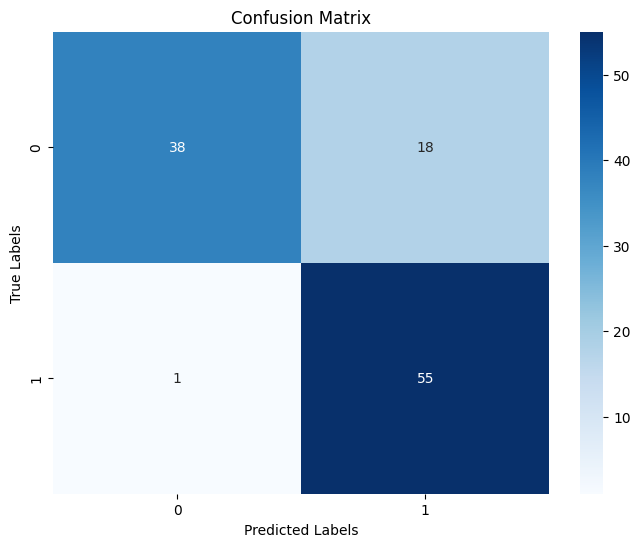

In [42]:
evaluate_model(train_loader, model, device)